# Mounting Goolge drive.

First add the data to your google drive using the following link:

https://drive.google.com/drive/folders/1I0MTQwn2HXquEiXdtntgRggqw6xJr47b?usp=sharing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Installing required packages

GPU and available memory check

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=4fc2438127d295347b079e24fd80f0321fb9046f79601e49686df306e7c5fe4d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  |     Proc size: 111.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


Transformers for general purpose NLP models

Unidecode for ASCII translation of Unicode text.

In [ ]:
!pip3 install transformers
!pip3 install unidecode

     |████████████████████████████████| 1.3MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 30.1MB/s 
     |████████████████████████████████| 1.1MB 58.3MB/s 
     |████████████████████████████████| 890kB 64.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=baa3f2d478b4cb569aec2d75d637608f2a3f3120357ae25f01e3f17df4ae14ad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 245kB 8.4MB/s 


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import join
import unidecode
import re
import logging
from tqdm.notebook import tnrange
import glob
import json

#For ploting results
import matplotlib.pyplot as plt

# DL Libraries
from transformers import BertModel, AdamW, BertTokenizer, BertConfig, RobertaTokenizer, RobertaModel
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("device: {} n_gpu: {}".format(device, n_gpu)) 

device: cuda n_gpu: 1


In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
print(logger)

<Logger __main__ (INFO)>


#Data Processing

Function to tokenize input dataframe (Query, Sentence, Label) and return tensorDatset with corresponding input_id, attention_masks and labels as a PyTorch dataloader. 

In [ ]:
def create_dataloader(tokenizer, df):
    input_ids= list()
    attention_masks= list()

    print("Shape: {}".format(df.shape))

    special_sentences_1 = [sentence for i, sentence in enumerate(df.question)]
    special_sentences_2 = [" [SEP] " + str(sentence) for i, sentence in enumerate(df.sentence)]
    special_sentences = [i + j for i, j in zip(special_sentences_1, special_sentences_2)]

    for sentence in special_sentences:
      encoded_text = tokenizer.encode_plus(sentence, max_length=512, add_special_tokens=True, return_token_type_ids=False, 
                                       padding='max_length', return_attention_mask=True, truncation=True)
      input_ids.append(encoded_text['input_ids'])
      attention_masks.append(encoded_text['attention_mask'])

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)
    gold_labels = torch.tensor(df.sia_score.tolist()).to(device)
  
    data = TensorDataset(inputs, masks, gold_labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=4)

    return dataloader

To load the dataset from google drive.

**!!! Please change the directory accordingly !!!**

Performing the train-test split after shuffling the dataset.

In [ ]:
load_data= '/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset'

data_df= pd.read_csv(join(load_data,'qasc_train_40k.csv'))
data_df= shuffle(data_df)

train_df, test_df= train_test_split(data_df, test_size=0.2)

Loading pretrained 'roberta-base' tokenizer and creating dataloader for train & test dataframes.

In [ ]:
#Dataloaders
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataloader= create_dataloader(tokenizer, train_df)
test_dataloader= create_dataloader(tokenizer, test_df)

11/15/2020 19:14:25 - INFO - filelock -   Lock 140302031761080 acquired on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


11/15/2020 19:14:26 - INFO - filelock -   Lock 140302031761080 released on /root/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


11/15/2020 19:14:26 - INFO - filelock -   Lock 140302031761080 acquired on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


11/15/2020 19:14:27 - INFO - filelock -   Lock 140302031761080 released on /root/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock



Shape: (32000, 3)
Shape: (8000, 3)


# Model

Model: 'roberta-base' with a Linear layer on top to generate SIA scores.

In [ ]:
#Class for Regression
class Regressor(nn.Module):

  def __init__(self):
    super(Regressor, self).__init__()
    self.bert = RobertaModel.from_pretrained('roberta-base')
    self.out = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    output, pooler_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    score= self.out(pooler_out)
    return score
    

Model Initialization with:

* 10 epochs

* 'AdamW' optimizer

* Mean Squared Error (MSE) Loss function

In [ ]:
#Model Intialization

epochs=10

#Load Model
model= Regressor()
model.to(device)

# Prepare optimizer
optimizer = AdamW(model.parameters(),lr=2e-5)

#Loss Function
mse_loss= nn.MSELoss().to(device)

11/15/2020 19:14:54 - INFO - filelock -   Lock 140299533510640 acquired on /root/.cache/torch/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


11/15/2020 19:14:54 - INFO - filelock -   Lock 140299533510640 released on /root/.cache/torch/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


11/15/2020 19:14:54 - INFO - filelock -   Lock 140299576170368 acquired on /root/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


11/15/2020 19:15:36 - INFO - filelock -   Lock 140299576170368 released on /root/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


#Training and Evaluation

Creating output directory:

model path: '/content/drive/My Drive/project_nlp/sia_experiment/model1'

result path: '/content/drive/My Drive/project_nlp/sia_experiment/results1'

In [ ]:
output_dir= '/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/model_QASCrobertabase_40ktraindataset_10epochs'
output_result= '/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

if not os.path.exists(output_result):
  os.makedirs(output_result)

Model training followed by model evaluation

In [ ]:
for iteration in tnrange(epochs, desc='Epochs'):
  model.train()
  logger.info("Running for iteration: {}".format(iteration+1))

  training_loss, training_steps=0,0
  true_labels, predicted_labels= list(), list()
  
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    ip_ids, masks, gold_labels= batch
    score = model(ip_ids, attention_mask=masks)
    score = score.squeeze(1)
    loss= mse_loss(score, gold_labels.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    training_loss+=loss.item()
    training_steps+=1
    if (step+1)%10000 == 0:
      print(step+1)

    true_labels.extend(gold_labels.cpu().numpy())
    predicted_labels.extend(score.detach().cpu().numpy())
  
  training_loss_for_epoch= training_loss/training_steps
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  accuracy=r2_score(true_labels, predicted_labels)
  result = {'loss': training_loss_for_epoch, 'PCC': pcc[0], 'RMSE':rmse, 'R2_score':accuracy}
  print(result)

  model_to_save = model.bert.module if hasattr(model.bert, 'module') else model.bert
  model_to_save.save_pretrained(output_dir)

  torch.save(model.out.state_dict(), join(output_dir, 'model_state.bin'))

  #Testing
  print("Running evaluation for epoch: {}".format(iteration+1))

  true_labels, predicted_labels= list(), list()
  model.eval()
  with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
      batch = tuple(t.to(device) for t in batch)
      ip_ids, masks, gold_labels= batch
      score = model(ip_ids, attention_mask=masks)
      score = score.squeeze(1)

      true_labels.extend(gold_labels.cpu().numpy())
      predicted_labels.extend(score.detach().cpu().numpy())
  
  pcc= pearsonr(true_labels, predicted_labels)
  rmse= mean_squared_error(true_labels, predicted_labels, squared=False)
  accuracy=r2_score(true_labels, predicted_labels)
  test_report= {'PCC': pcc[0], 'RMSE':str(rmse), 'R2_score':str(accuracy)}
  print(test_report)

  with open(join(output_result, 'result_'+str(iteration+1)+'.json'), 'w') as fp:
    json.dump(test_report, fp)

11/15/2020 03:26:54 - INFO - __main__ -   Running for iteration: 1


{'loss': 0.316948220959006, 'PCC': 0.858252803836929, 'RMSE': 0.56298155, 'R2_score': 0.7362694053764729}
Running evaluation for epoch: 1


11/15/2020 04:01:58 - INFO - __main__ -   Running for iteration: 2


{'PCC': 0.8979805223259498, 'RMSE': '0.50079584', 'R2_score': '0.7904944670123933'}
{'loss': 0.2212345151767513, 'PCC': 0.9033047344949144, 'RMSE': 0.47035575, 'R2_score': 0.8159121588982058}
Running evaluation for epoch: 2


11/15/2020 04:37:02 - INFO - __main__ -   Running for iteration: 3


{'PCC': 0.9094765989371809, 'RMSE': '0.46191233', 'R2_score': '0.8217649542315048'}
{'loss': 0.17380989143368789, 'PCC': 0.9248766032252225, 'RMSE': 0.41690513, 'R2_score': 0.8553738887145862}
Running evaluation for epoch: 3


11/15/2020 05:12:05 - INFO - __main__ -   Running for iteration: 4


{'PCC': 0.9156299878892413, 'RMSE': '0.44493178', 'R2_score': '0.83462841922913'}
{'loss': 0.1494600441532748, 'PCC': 0.935762721466353, 'RMSE': 0.38660064, 'R2_score': 0.875635242519454}
Running evaluation for epoch: 4


11/15/2020 05:47:07 - INFO - __main__ -   Running for iteration: 5


{'PCC': 0.9152833553872414, 'RMSE': '0.45028162', 'R2_score': '0.8306276773726227'}
{'loss': 0.12332130304044403, 'PCC': 0.9473086608556127, 'RMSE': 0.3511713, 'R2_score': 0.8973851236104324}
Running evaluation for epoch: 5


11/15/2020 06:22:09 - INFO - __main__ -   Running for iteration: 6


{'PCC': 0.9188627585177381, 'RMSE': '0.44012833', 'R2_score': '0.8381798158688042'}
{'loss': 0.10595071901914525, 'PCC': 0.9549068179909379, 'RMSE': 0.32550073, 'R2_score': 0.9118390767606472}
Running evaluation for epoch: 6


11/15/2020 06:57:11 - INFO - __main__ -   Running for iteration: 7


{'PCC': 0.9130338714252875, 'RMSE': '0.4476361', 'R2_score': '0.8326120364246362'}
{'loss': 0.0917778914096034, 'PCC': 0.9610606841018872, 'RMSE': 0.30294865, 'R2_score': 0.9236321970252168}
Running evaluation for epoch: 7


11/15/2020 07:32:13 - INFO - __main__ -   Running for iteration: 8


{'PCC': 0.9160084275279966, 'RMSE': '0.44207308', 'R2_score': '0.8367466389865281'}
{'loss': 0.08444063032502527, 'PCC': 0.9642308147659806, 'RMSE': 0.29058668, 'R2_score': 0.9297374855472638}
Running evaluation for epoch: 8


11/15/2020 08:07:18 - INFO - __main__ -   Running for iteration: 9


{'PCC': 0.9195819913636367, 'RMSE': '0.44827202', 'R2_score': '0.8321361391442683'}
{'loss': 0.07514111007013344, 'PCC': 0.9682347542115222, 'RMSE': 0.2741188, 'R2_score': 0.9374755575275201}
Running evaluation for epoch: 9


11/15/2020 08:42:22 - INFO - __main__ -   Running for iteration: 10


{'PCC': 0.9208929302438675, 'RMSE': '0.4273876', 'R2_score': '0.847412896861006'}
{'loss': 0.06918799543561363, 'PCC': 0.9707894576520302, 'RMSE': 0.2630361, 'R2_score': 0.9424291066194148}
Running evaluation for epoch: 10
{'PCC': 0.9165741118469044, 'RMSE': '0.44762945', 'R2_score': '0.832617001662687'}



# Visualizing the results

In [ ]:
filepaths= glob.glob(join(output_result,'*.json'))

pcc, rmse= list(), list()

for path in filepaths:
  print(path)
  f = open(path,'r')
  data = json.load(f)
  pcc.append(data['PCC'])  
  rmse.append(float(data['RMSE']))

/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_1.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_2.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_3.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_4.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_5.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_6.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/results_baseroberta_QASC_40ktraindataset_10epochs/result_7.json
/content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_exp

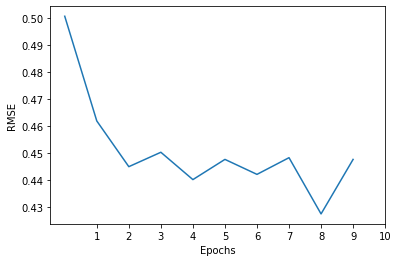

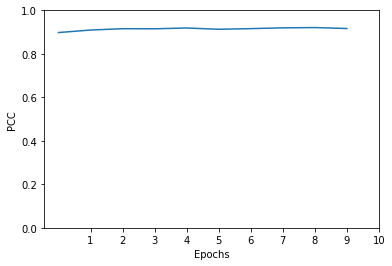

In [ ]:
#plot rmse
plt.plot(rmse)
plt.ylabel('RMSE')
plt.xticks(range(1, 11))
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'rmse.png'))
plt.show()

#plot
plt.plot(pcc)
plt.ylabel('PCC')
plt.xticks(range(1, 11))
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'pcc.png'))
plt.show() 

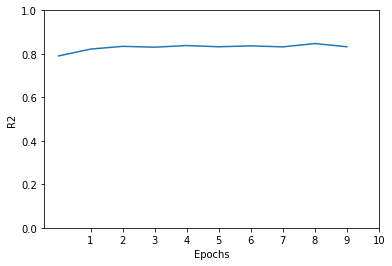

In [ ]:
#plot
accuracy=[0.7904944670123933,0.8217649542315048,0.83462841922913,0.8306276773726227,0.8381798158688042,0.8326120364246362,0.8367466389865281,0.8321361391442683,0.847412896861006,0.832617001662687]
plt.plot(accuracy)
plt.ylabel('R2')
plt.xticks(range(1, 11))
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.savefig(join(output_result, 'R2.png'))
plt.show() 

In [ ]:
!pip install allennlp==0.4.2


     |████████████████████████████████| 716kB 9.7MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
     |████████████████████████████████| 512kB 20.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 496.4MB 30kB/s 
     |████████████████████████████████| 430kB 70.2MB/s 
     |████████████████████████████████| 3.5MB 64.3MB/s 
     |████████████████████████████████| 25.2MB 127kB/s 
     |████████████████████████████████| 1.7MB 54.3MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 6.8MB 55.6MB/s 
     |████████████████████████████████| 552kB 63.2MB/s 
     |████████████████████████████████| 1.9MB 43.9MB/s 
     |████████████████████████████████| 614kB 54.1MB/s 
     |████████████████████████████████| 153kB 52.6MB/s 
     |████████████████████████████████| 184kB 58.8MB/s 


In [ ]:
!python -m allennlp.run predict \
     --include-package qasc \
     --predictor multiple-choice-qa-json \
     --output-file data/nokb_predictions.jsonl \
     /content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/sia_experiment/model_QASCrobertabase_40ktraindataset_10epochs/model_state.bin  \
     /content/drive/My Drive/QASC-DATASET/data/QASC_Dataset/test.jsonl

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
usage: python -m allennlp.run predict [-h] [--output-file OUTPUT_FILE]
                                      [--weights-file WEIGHTS_FILE]
                                      [--batch-size BATCH_SIZE] [--silent]
                                      [--cuda-device CUDA_DEVICE]
                                      [-o OVERRIDES] [--predictor PREDICTOR]
                                      [--include-package INCLUDE_PACKAGE]
 